#### Loading the necessary libraries and packages

In [1]:
# Load tensorflow
import tensorflow as tf
# Below command is to avoid the known bug which prevents computation on some GPU devices
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)
# Load preprocessing tools
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scipy.ndimage.filters import gaussian_filter
from PIL import Image
from PIL.ImageOps import expand
# Load model building blocks
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
# Load pre-trained model library
from tensorflow.keras import applications
# Load miscelaneous libraries
import numpy as np
import os
import matplotlib.pylab as plt
import gc

#### Define paths

In [2]:
train_image_path = os.path.join('/home', 'renat_sergazinov', 
                          'python-git-workspace', 'PhotoForceReconML', 'image_data', 'small', '4000', 'train')
val_image_path = os.path.join('/home', 'renat_sergazinov', 
                          'python-git-workspace', 'PhotoForceReconML', 'image_data', 'small', '4000', 'val')
load_model_path = os.path.join('/home', 'renat_sergazinov', 'python-git-workspace', 
                               'PhotoForceReconML', 'models', 'vgg19_num_forces.h5')
save_model_path = os.path.join('/home', 'renat_sergazinov', 'python-git-workspace', 
                               'PhotoForceReconML', 'models', 'small', '4000', 'vgg19_num_forces.h5')

#### Data preprocessing and augmentation

Load the data from the directory. The data are the images of particles split into subdirectories based on the number of forces acting on the particle. The labels are inferred from the subdirectory names. 

The size of all images is adjusted so that all images are 128*128 using nearest neighbor interpolation. Validation split is performed: 20% is set aside for validation. Additionally images are blurred using Gaussian blur with kernel radius = 1.The pixel values are scaled using 1/255 to be in the interval [0,1].

In [3]:
# Define gaussian blur class
class GaussBlur:
    def __init__(self, radius):
        self.radius = radius
    def blur(self, image):
        return gaussian_filter(image, sigma = self.radius)

In [4]:
# Define datagen and gaussian blur classes
gaussblur = GaussBlur(1)
datagen = ImageDataGenerator(
    rescale = 1 / 255,
    preprocessing_function = gaussblur.blur)

In [5]:
# Create directory iterator for reading in the data
datagen_flow_train = datagen.flow_from_directory(train_image_path, 
                                         target_size = (128, 128),
                                         color_mode = "rgb",
                                         class_mode = "categorical",
                                         batch_size = 32,
                                         shuffle = True,
                                         seed = None,
                                         follow_links = False,
                                         interpolation = "nearest")
datagen_flow_val = datagen.flow_from_directory(val_image_path, 
                                         target_size = (128, 128),
                                         color_mode = "rgb",
                                         class_mode = "categorical",
                                         batch_size = 32,
                                         shuffle = True,
                                         seed = None,
                                         follow_links = False,
                                         interpolation = "nearest")

Found 16000 images belonging to 5 classes.
Found 4000 images belonging to 5 classes.


#### VGG19 Model building

Convolutional neural network is loaded (pre-trained) and compiled in this step.

In [6]:
# Load VGG19 model to be the base model
model = load_model(load_model_path)   

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5125      
Total params: 20,554,821
Trainable params: 20,554,821
Non-trainable params: 0
_________________________________________________

#### VGG19 Model Training

The model is trained using Adam optimizer. The loss is defined to be categorical crossentropy. Best model selection across training epochs is implemented with model checkpoint tracking the validation loss. Early stopping is set with patience of 20 epochs. 

In [8]:
# Compile model: define loss, optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-06, epsilon = 1e-07),
              loss='categorical_crossentropy', 
              metrics=['accuracy', 'categorical_crossentropy'])

In [9]:
# Train model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint(save_model_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

epochs = 1000

history = model.fit(datagen_flow_train,
                            epochs = epochs,
                            steps_per_epoch = len(datagen_flow_train),
                            validation_data = datagen_flow_val,
                            validation_steps = len(datagen_flow_val),
                            callbacks=[es, mc]
                           )

Epoch 1/1000
500/500 [==============================] - ETA: 0s - loss: 0.4409 - accuracy: 0.9589 - categorical_crossentropy: 0.4409
Epoch 00001: val_loss improved from inf to 0.04056, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/vgg19_num_forces.h5
500/500 [==============================] - 59s 117ms/step - loss: 0.4409 - accuracy: 0.9589 - categorical_crossentropy: 0.4409 - val_loss: 0.0406 - val_accuracy: 0.9890 - val_categorical_crossentropy: 0.0406
Epoch 2/1000
500/500 [==============================] - ETA: 0s - loss: 0.0784 - accuracy: 0.9818 - categorical_crossentropy: 0.0784
Epoch 00002: val_loss improved from 0.04056 to 0.02134, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/vgg19_num_forces.h5
500/500 [==============================] - 56s 111ms/step - loss: 0.0784 - accuracy: 0.9818 - categorical_crossentropy: 0.0784 - val_loss: 0.0213 - val_accuracy: 0.9925 - val_categorical

Epoch 19/1000
500/500 [==============================] - ETA: 0s - loss: 0.0028 - accuracy: 0.9990 - categorical_crossentropy: 0.0028
Epoch 00019: val_loss did not improve from 0.00220
500/500 [==============================] - 55s 111ms/step - loss: 0.0028 - accuracy: 0.9990 - categorical_crossentropy: 0.0028 - val_loss: 0.0060 - val_accuracy: 0.9983 - val_categorical_crossentropy: 0.0060
Epoch 20/1000
500/500 [==============================] - ETA: 0s - loss: 0.0023 - accuracy: 0.9992 - categorical_crossentropy: 0.0023
Epoch 00020: val_loss improved from 0.00220 to 0.00215, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/vgg19_num_forces.h5
500/500 [==============================] - 56s 111ms/step - loss: 0.0023 - accuracy: 0.9992 - categorical_crossentropy: 0.0023 - val_loss: 0.0021 - val_accuracy: 0.9995 - val_categorical_crossentropy: 0.0021
Epoch 21/1000
500/500 [==============================] - ETA: 0s - loss: 0.0016 - accuracy: 0

Epoch 39/1000
500/500 [==============================] - ETA: 0s - loss: 7.3457e-04 - accuracy: 0.9998 - categorical_crossentropy: 7.3457e-04
Epoch 00039: val_loss did not improve from 0.00022
500/500 [==============================] - 55s 111ms/step - loss: 7.3457e-04 - accuracy: 0.9998 - categorical_crossentropy: 7.3457e-04 - val_loss: 0.0021 - val_accuracy: 0.9990 - val_categorical_crossentropy: 0.0021
Epoch 40/1000
500/500 [==============================] - ETA: 0s - loss: 0.0031 - accuracy: 0.9990 - categorical_crossentropy: 0.0031
Epoch 00040: val_loss did not improve from 0.00022
500/500 [==============================] - 55s 110ms/step - loss: 0.0031 - accuracy: 0.9990 - categorical_crossentropy: 0.0031 - val_loss: 8.0040e-04 - val_accuracy: 0.9995 - val_categorical_crossentropy: 8.0040e-04
Epoch 41/1000
500/500 [==============================] - ETA: 0s - loss: 3.1696e-04 - accuracy: 0.9999 - categorical_crossentropy: 3.1696e-04
Epoch 00041: val_loss improved from 0.00022 to 0

500/500 [==============================] - ETA: 0s - loss: 0.0029 - accuracy: 0.9991 - categorical_crossentropy: 0.0029
Epoch 00058: val_loss did not improve from 0.00003
500/500 [==============================] - 55s 110ms/step - loss: 0.0029 - accuracy: 0.9991 - categorical_crossentropy: 0.0029 - val_loss: 0.0014 - val_accuracy: 0.9990 - val_categorical_crossentropy: 0.0014
Epoch 59/1000
500/500 [==============================] - ETA: 0s - loss: 8.2632e-05 - accuracy: 1.0000 - categorical_crossentropy: 8.2632e-05
Epoch 00059: val_loss did not improve from 0.00003
500/500 [==============================] - 55s 111ms/step - loss: 8.2632e-05 - accuracy: 1.0000 - categorical_crossentropy: 8.2632e-05 - val_loss: 8.0287e-04 - val_accuracy: 0.9998 - val_categorical_crossentropy: 8.0287e-04
Epoch 60/1000
500/500 [==============================] - ETA: 0s - loss: 1.0331e-04 - accuracy: 1.0000 - categorical_crossentropy: 1.0331e-04
Epoch 00060: val_loss did not improve from 0.00003
500/500 [==

Epoch 78/1000
500/500 [==============================] - ETA: 0s - loss: 0.0016 - accuracy: 0.9996 - categorical_crossentropy: 0.0016
Epoch 00078: val_loss did not improve from 0.00003
500/500 [==============================] - 55s 110ms/step - loss: 0.0016 - accuracy: 0.9996 - categorical_crossentropy: 0.0016 - val_loss: 0.0011 - val_accuracy: 0.9995 - val_categorical_crossentropy: 0.0011
Epoch 79/1000
500/500 [==============================] - ETA: 0s - loss: 0.0016 - accuracy: 0.9994 - categorical_crossentropy: 0.0016
Epoch 00079: val_loss did not improve from 0.00003
500/500 [==============================] - 55s 110ms/step - loss: 0.0016 - accuracy: 0.9994 - categorical_crossentropy: 0.0016 - val_loss: 2.9949e-04 - val_accuracy: 1.0000 - val_categorical_crossentropy: 2.9949e-04
Epoch 80/1000
500/500 [==============================] - ETA: 0s - loss: 0.0010 - accuracy: 0.9995 - categorical_crossentropy: 0.0010
Epoch 00080: val_loss did not improve from 0.00003
500/500 [============

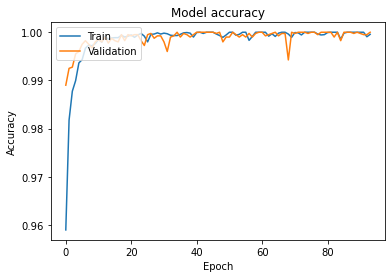

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()